In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from keras.utils.np_utils import to_categorical

In [2]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df=pd.read_csv('mitbih_train.csv',header=None)
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [4]:
test_df=pd.read_csv('mitbih_test.csv',header=None)

In [5]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()

In [6]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [8]:
Model_train=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [9]:
Model_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
51560,0.963979,0.919383,0.554031,0.126930,0.118353,0.173242,0.150943,0.145798,0.154374,0.140652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72959,0.991489,0.782979,0.144681,0.000000,0.106383,0.182979,0.140426,0.191489,0.255319,0.246809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
74948,0.000000,0.033981,0.142395,0.221683,0.297735,0.372168,0.428803,0.464401,0.496764,0.521036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80861,0.946593,1.000000,0.563536,0.211786,0.136280,0.097606,0.075506,0.064457,0.058932,0.049724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
84299,0.641422,0.527048,0.431221,0.313756,0.204019,0.103555,0.044822,0.000000,0.009274,0.023184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


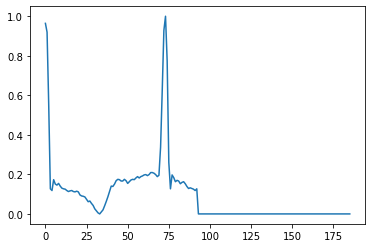

In [10]:
 plt.plot(Model_train.iloc[0,:186])

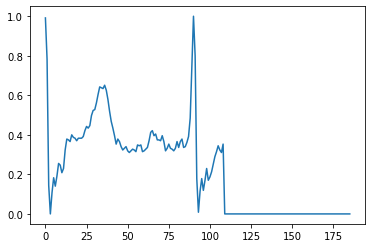

In [11]:
 plt.plot(Model_train.iloc[1,:186])

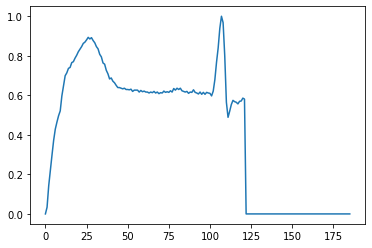

In [12]:
 plt.plot(Model_train.iloc[2,:186])

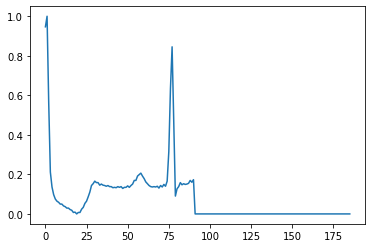

In [13]:
 plt.plot(Model_train.iloc[3,:186])

In [14]:
def add_gaussian_noise(code):
    noise=np.random.normal(0,0.5,186)
    return (code+noise)

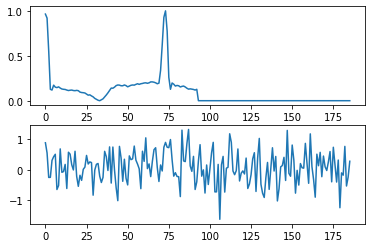

In [25]:
temp=Model_train.iloc[0,:186]
bruiter=add_gaussian_noise(temp)

plt.subplot(2,1,1)
plt.plot(Model_train.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [26]:
fig, axes= plt.subplots(math.ceil(len(Classes_index.keys())/2), 2, figsize=(20,30), constrained_layout=True)
X = np.arange(0, len(feat_cols_name))*8/1000

i = 0
for key, value in Classes_index.items():
    ax = axes[int(i/2), i%2]
    ax.plot(X, train_df[train_df["label"] == key][feat_cols_name].sample(1).values.reshape(-1,1))
    ax.legend()
    ax.set(title="1-beat ECG for Cat {}".format(key))
    ax.set(ylabel="Amplitude")
    ax.set(xlabel="Time (ms)")
    i+=1

NameError: name 'math' is not defined

In [16]:
target_train=train_df[187]
target_test=test_df[187]

In [17]:
y_train=to_categorical(target_train)

In [18]:
y_test=to_categorical(target_test)

In [19]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [21]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [22]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [23]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/40
3125/3125 [==============================] - 95s 30ms/step - loss: 0.9009 - accuracy: 0.6543 - val_loss: 1.1009 - val_accuracy: 0.5067
Epoch 2/40
3125/3125 [==============================] - 143s 46ms/step - loss: 0.7983 - accuracy: 0.6966 - val_loss: 2.3258 - val_accuracy: 0.1270
Epoch 3/40
3125/3125 [==============================] - 147s 47ms/step - loss: 0.7632 - accuracy: 0.7100 - val_loss: 1.0429 - val_accuracy: 0.5801
Epoch 4/40
3125/3125 [==============================] - 168s 54ms/step - loss: 0.7389 - accuracy: 0.7188 - val_loss: 1.1620 - val_accuracy: 0.4535
Epoch 5/40
3125/3125 [==============================] - 107s 34ms/step - loss: 0.7128 - accuracy: 0.7285 - val_loss: 0.9563 - val_accuracy: 0.6105
Epoch 6/40
3125/3125 [==============================] - 106s 34ms/step - loss: 0.6881 - accuracy: 0.7374 - val_loss: 0.8403 - val_accuracy: 0.7067
Epoch 7/40
3125/3125 [==============================] - 96s 31ms/step - loss: 0.6622 - accuracy: 0.7495 - val_loss: 0.9

Accuracy: 70.67%


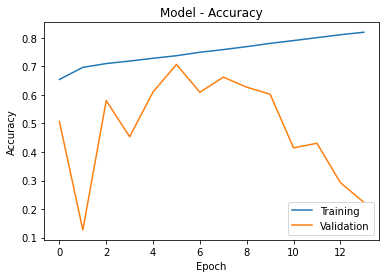

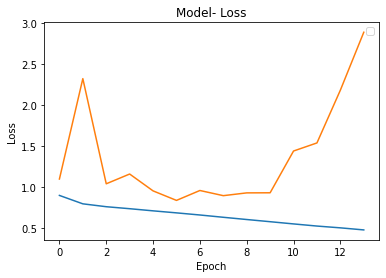

In [24]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)